In [61]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, Literal, NotRequired
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from dotenv import load_dotenv
import os
from pydantic import BaseModel, Field
from google import genai
from google.genai.types import GenerateContentConfig
import operator

In [62]:
load_dotenv()
client = genai.Client(api_key=os.getenv("GOOGLE_API_KEY"))

In [63]:
#TEST

# 1. Load the environment variables
loaded = load_dotenv()

# 2. Get the key
api_key = os.getenv("GOOGLE_API_KEY") # Make sure this name matches your .env file exactly

print(f"1. Did .env file load? -> {loaded}")
print(f"2. Is api_key variable found? -> {api_key is not None}")

if api_key:
    # Print only the first 4 characters for safety
    print(f"3. Key starts with: {api_key[:4]}...")
    print(f"4. Key length: {len(api_key)}")
else:
    print("3. RESULT: The code cannot read the variable. Check your .env file.")

1. Did .env file load? -> True
2. Is api_key variable found? -> True
3. Key starts with: AIza...
4. Key length: 39


In [64]:

# Generator Use "gemini-1.5-flash" or "gemini-2.0-flash-exp"
try:
    generator = client.models.generate_content(
        model="gemini-2.5-flash", 
        contents="What is the sentiment of the following reviews - Software is too good.",
    )
    
    # 5. Validate and print

    print(f"Result: {generator.text}")

except Exception as e:
    print(f"An error occurred: {e}")


# # Use "gemini-1.5-flash" or "gemini-2.0-flash-exp"
# try:
#     generator = client.models.generate_content(
#         model="gemini-2.0-flash-exp", 
#         contents="What is the sentiment of the following reviews - Software is too good.",
#     )
    
#     # 5. Validate and print

#     print(f"Result: {generator.text}")

# except Exception as e:
#     print(f"An error occurred: {e}")

Result: The sentiment of "Software is too good" is **highly positive**.

While "too" can sometimes imply an excessive negative (e.g., "too hot," "too expensive"), when paired with "good" in this context, it acts as an intensifier, meaning "exceptionally good," "outstanding," or "surprisingly excellent." It's a way of expressing strong satisfaction.


In [65]:
#State
class TweetState(TypedDict):
    topic: str
    tweet: str
    evaluation: Literal["Approved", "Needs_Improvement"]
    feedback: str
    iteration: int
    max_iteration: int

    tweet_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]

In [66]:
def generate_tweet(state:TweetState)->TweetState:
    system_instructions = "You are a funny and clever Twitter/X influencer."
    config = GenerateContentConfig(
        system_instruction=system_instructions,
        temperature=0.5
    )
    #prompt
    human_message=f"""
        Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

        Rules:
        - Do NOT use question-answer format.
        - Max 280 characters.
        - Use observational humor, irony, sarcasm, or cultural references.
        - Think in meme logic, punchlines, or relatable takes.
        - Use simple, day to day english
        - This is version {state['iteration']+1}
        """
    
    try:
        # 6. Call the model
        # Note: "gemini-2.5-flash" does not exist yet. Use 1.5-flash or 2.0-flash-exp.
        response = client.models.generate_content(
            model="gemini-2.5-flash", 
            contents=human_message,  # This is the "Human Message"
            config=config            # This contains the "System Message"
        )
        
        # 7. Print result
        print(f"Result: {response.text}")

    except Exception as e:
        print(f"An error occurred: {e}")


    #return response
    return {'tweet': response.text, 'tweet_history': [response.text]}


In [67]:
class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description= "Final evaluation result.")
    feedback: str = Field(..., description="Constructive Feedback for the tweet.")
    

In [68]:
def evaluate_tweet(state:TweetState)->TweetState:
    system_instructions = "You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."

    schema = TweetEvaluation.model_json_schema()

    #parsing
    config = GenerateContentConfig(
        response_mime_type="application/json",
        response_schema=schema,
        system_instruction=system_instructions,
        temperature=0.5
    )

    #prompt
    human_message = f"""
        Evaluate the following tweet:

        Tweet: "{state['tweet']}"

        Use the criteria below to evaluate the tweet:

        1. Originality - Is this fresh, or have you seen it a hundred times before?  
        2. Humor - Did it genuinely make you smile, laugh, or chuckle?  
        3. Punchiness - Is it short, sharp, and scroll-stopping?  
        4. Virality Potential - Would people retweet or share it?  
        5. Format - Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

        Auto-reject if:
        - It's written in question-answer format (e.g., "Why did..." or "What happens when...")
        - It exceeds 280 characters
        - It reads like a traditional setup-punchline joke
        - Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

        ### Respond ONLY in structured format:
        - evaluation: "approved" or "needs_improvement"  
        - feedback: One paragraph explaining the strengths and weaknesses 
        """

    
    try:
        # 6. Call the model
        # Note: "gemini-2.5-flash" does not exist yet. Use 1.5-flash or 2.0-flash-exp.
        response = client.models.generate_content(
            model="gemini-2.5-flash", 
            contents=human_message,  # This is the "Human Message"
            config=config            # This contains the "System Message"
        )
        
        # 7. Print result
        # 5. Validate and print
        result = TweetEvaluation.model_validate_json(response.text)
        return {'evaluation': result.evaluation, 'feedback': result.feedback, 'feedback_history': state['feedback_history'] + [result.feedback]}

    except Exception as e:
        print(f"An error occurred: {e}")


    

In [69]:
def optimize_tweet(state: TweetState)->TweetState:
    
    system_instructions = "You punch up tweets for virality and humor based on given feedback."
    config = GenerateContentConfig(
        system_instruction=system_instructions,
        temperature=0.5
    )
    #prompt
    human_message=f"""
        Improve the tweet based on this feedback:
        "{state['feedback']}"

        Topic: "{state['topic']}"
        Original Tweet:
        {state['tweet']}

        Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
        """
    
    try:
        # 6. Call the model
        # Note: "gemini-2.5-flash" does not exist yet. Use 1.5-flash or 2.0-flash-exp.
        response = client.models.generate_content(
            model="gemini-2.5-flash", 
            contents=human_message,  # This is the "Human Message"
            config=config            # This contains the "System Message"
        )
        
        iteration  = state['iteration'] + 1
        # 7. Print result
        print(f"Result: {response.text}")

    except Exception as e:
        print(f"An error occurred: {e}")


    #return response
    return {'tweet': response.text, 'iteration': iteration, 'tweet_history': state['tweet_history'] + [response.text]}
    
    

In [70]:
def route_evaluation(state:TweetState)->TweetState:
    if state['evaluation'] == "approved" or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvement'

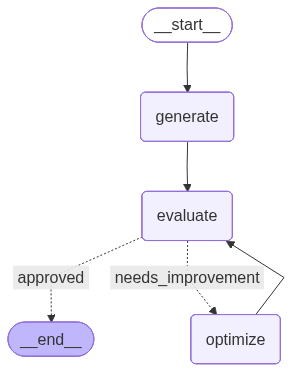

In [71]:
graph = StateGraph(TweetState)

#Nodes
graph.add_node("generate", generate_tweet)
graph.add_node("evaluate", evaluate_tweet)
graph.add_node("optimize", optimize_tweet)

graph.add_edge(START, 'generate')
graph.add_edge('generate', 'evaluate')
graph.add_conditional_edges('evaluate', route_evaluation, {
    'approved': END,
    'needs_improvement': 'optimize'})
graph.add_edge('optimize', 'evaluate')


workflow = graph.compile()


workflow

In [76]:
initial_state = {
    "topic": "Vague Instructions",
    "iteration": 1,
    "max_iteration": 5
    
}

workflow.invoke(initial_state)

An error occurred: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 20, model: gemini-2.5-flash\nPlease retry in 48.614308273s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerDayPerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gem

UnboundLocalError: cannot access local variable 'response' where it is not associated with a value